In [3]:
import re
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
from sklearn import metrics
import matplotlib.pylab as plt


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total=pd.concat([train,test])
PassengerId=total['PassengerId']

In [5]:
def fill_features(df):
    df['Embarked'].fillna('S',inplace=True)
    df['Fare'].fillna(df['Fare'].median(),inplace=True)
    mu=df['Age'].mean()
    delta=df['Age'].std()
    rand_list=np.random.randint(mu-delta,mu+delta,size=df['Age'].isnull().sum())
    df.loc[df['Age'].isnull(), 'Age']=rand_list
    df['Age']=df['Age'].astype(int)
    return df


In [6]:
def add_features(df):
    df['FamilySize']=df['SibSp']+df['Parch']+1
    df['IsAlone']=1
    df.loc[df['FamilySize']>1, 'IsAlone']=0
    df['HasCabin']=df['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
    return df
#total[['Embarked','Survived']].groupby('Embarked', as_index=False).mean()

In [7]:
def simplify_features(df):
    df=simplify_fare(df)
    df=simplify_ages(df)
    df=simplify_title(df)
    return df

In [8]:
def simplify_fare(df):
    bins=(-1,0,7.896,14.454,31.275,512.4)
    tags=['unknown', 'first','second','third','forth']
    df['Fare']=pd.cut(df['Fare'], bins, tags)
    return df
#df['FareCategorical']=pd.qcut(df['Fare'],4)
#df[['FareCategorical','Survived']].groupby('FareCategorical', as_index=False).mean()

def simplify_ages(df):
    bins=(-1,0,5,12,18,25,35,60,120)
    tags = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    df['Age'] = pd.cut(df['Age'],bins , labels=tags) 
    return df

#total['AgeCategorical']=pd.cut(total['Age'],5)
#total[['AgeCategorical','Survived']].groupby('AgeCategorical', as_index=False).mean()

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def simplify_title(df):
    df['Title'] = df['Name'].apply(get_title)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    return df


In [9]:
def drop_features(df):
    df.drop('PassengerId',axis=1,inplace=True)
    df.drop('Name',axis=1,inplace=True)
    df.drop('Cabin',axis=1,inplace=True)
    df.drop('SibSp',axis=1,inplace=True)
    #total.drop('Parch',axis=1,inplace=True)
    df.drop('Ticket',axis=1,inplace=True)
    return df


In [10]:
total=fill_features(total)
total=add_features(total)
total=simplify_features(total)
total=drop_features(total)

In [11]:
def encode_features(df):
    features = ['Fare', 'Age', 'Embarked', 'Sex', 'Title']
    for feature in features:
        le=pp.LabelEncoder()
        le=le.fit(df[feature])
        df[feature]=le.transform(df[feature])
    return df
total=encode_features(total)

In [12]:
y_train=train['Survived']
total.drop('Survived', axis=1, inplace=True)
print total.columns
#x_all=total.iloc[range(len(train_y))]
train_all=total.iloc[range(len(y_train))]

Index([u'Age', u'Embarked', u'Fare', u'Parch', u'Pclass', u'Sex',
       u'FamilySize', u'IsAlone', u'HasCabin', u'Title'],
      dtype='object')


In [11]:

num_test=0.20
train_x,test_x,train_y,test_y = ms.train_test_split(x_all,y_all, test_size=num_test, random_state=23)

NameError: name 'x_all' is not defined

In [12]:
#train_y = train['Survived']

#total.drop('Survived', axis=1, inplace=True)


#total_array = total.as_matrix()

#train_x = total_array[:len(train_y),:]
#test_x = total_array[len(train_y):,:]




#predictions = gbm.predict(test_x)
#submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
#                            'Survived': predictions })
#submission.to_csv("submission.csv", index=False)


[0]	train-auc:0.86563	test-auc:0.852301
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[1]	train-auc:0.873263	test-auc:0.856922
[2]	train-auc:0.875543	test-auc:0.861053
[3]	train-auc:0.881224	test-auc:0.860448
[4]	train-auc:0.882865	test-auc:0.861186
[5]	train-auc:0.882898	test-auc:0.86124
[6]	train-auc:0.883662	test-auc:0.862763
[7]	train-auc:0.886148	test-auc:0.86303
[8]	train-auc:0.88691	test-auc:0.864701
[9]	train-auc:0.88779	test-auc:0.865276
[10]	train-auc:0.888243	test-auc:0.867063
[11]	train-auc:0.88847	test-auc:0.86758
[12]	train-auc:0.891294	test-auc:0.869548
[13]	train-auc:0.892588	test-auc:0.87082
[14]	train-auc:0.893355	test-auc:0.869677
[15]	train-auc:0.894814	test-auc:0.872569
[16]	train-auc:0.895967	test-auc:0.872801
[17]	train-auc:0.896216	test-auc:0.873925
[18]	train-auc:0.897073	test-auc:0.874764
[19]	train-auc:0.898071	test-auc:0.875116
[20]	train-auc:0.898394	test-auc:0.87

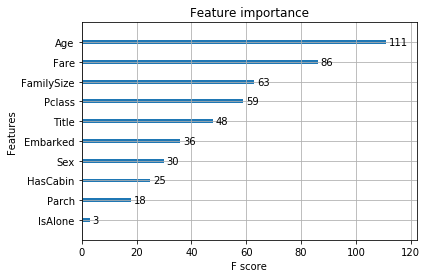

In [33]:
#param_grid = {'n_estimators'=
#              'max_depth':range(3,6,1), 
#              'min_child_weight':range(1,6,1),
#              'gamma':[i/10.0 for i in range(2,8)],
#              'subsample':[i/100.0 for i in range(60,100,5)],
#              'colsample_bytree':[i/100.0 for i in range(60,100,5)]}

model = xgb.XGBClassifier(learning_rate =0.1, 
                      n_estimators=1000, 
                      max_depth=8,
                      min_child_weight=4, 
                      gamma=0.8, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      n_jobs=4, 
                      scale_pos_weight=1,
                      random_state = 29)

xgbTrain = xgb.DMatrix(train_all.values, label=y_train.values)
xgbParams = model.get_xgb_params()
cv_result=xgb.cv(xgbParams,
                 xgbTrain,
                 num_boost_round=model.get_params()['n_estimators'],
                 nfold= 5,
                 metrics='auc',
                 early_stopping_rounds=50,
                 callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(50)],
                 )

model.set_params(n_estimators=cv_result.shape[0])
model.fit(train_all,y_train, eval_metric='auc')

predictions = model.predict(train_all)
pred_prob = model.predict_proba(train_all)[:,1]

print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(y_train.values, predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, pred_prob)
#grid = ms.GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, verbose=1)
#grid.fit(train_x,train_y)

xgb.plot_importance(model)
plt.show()

In [ ]:
#print (grid.best_score_)
#print (grid.best_params_)

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = ms.GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=51, max_depth=5,
 min_child_weight=3, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', n_jobs=4, scale_pos_weight=1), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_all, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


In [12]:
train_all.head(5)

,Age,Embarked,Fare,Parch,Pclass,Sex,FamilySize,IsAlone,HasCabin,Title
0,4,2,1,0,3,1,2,0,0,2
1,0,0,4,0,1,0,2,0,1,3
2,7,2,2,0,3,0,1,1,0,1
3,7,2,4,0,1,0,2,0,1,3
4,7,2,2,0,3,1,1,1,0,2
